In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("allenai/c4", "realnewslike")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Using the latest cached version of the dataset since allenai/c4 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'realnewslike' at /home/ShenChenchen/.cache/huggingface/datasets/allenai___c4/realnewslike/0.0.0/1588ec454efa1a09f29cd18ddd04fe05fc8653a2 (last modified on Tue Mar 26 12:00:09 2024).


Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [11]:
# len(dataset['validation']['text'])
len(dataset['validation'][0]['text'])
dataset['validation']

Dataset({
    features: ['text', 'timestamp', 'url'],
    num_rows: 13863
})

In [10]:
shorter = 0
longer = 0
threshold = 100
for i in range(len(dataset['validation']['text'])):
    if len((dataset['validation'][i]['text'])) < threshold:
        shorter +=1
    else:
        longer += 1
print(f"There's {shorter} samples with text length shorter than {threshold}")
print(f"There's {longer} samples with text length longer than {threshold}")

There's 16 samples with text length shorter than 100
There's 13847 samples with text length longer than 100


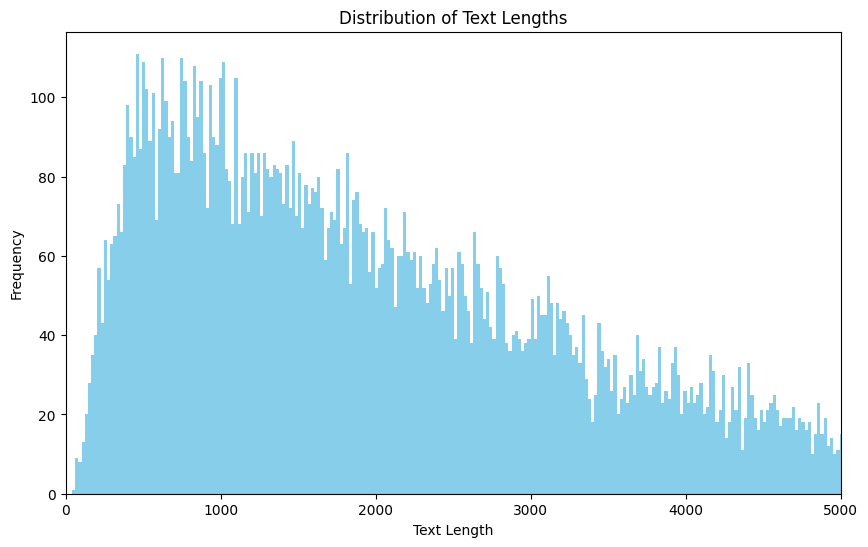

In [21]:
import matplotlib.pyplot as plt

# Plotting the distribution of text lengths
def plot_length_dist(dataset):
    text_lengths = [len(row['text']) for row in dataset]
    plt.figure(figsize=(10, 6))
    plt.hist(text_lengths, bins=5000, color='skyblue')  # Adjust 'bins' as needed for granularity
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.xlim(0, 5000)
    plt.show()

plot_length_dist(dataset['validation'])

Result evaluation

In [26]:
import json
import re
import numpy as np

In [ ]:
def extract_verdict(raw_input):
    pattern = r'([ABC])'
    matches = re.findall(pattern, raw_input)
    return matches

with open("./final_score.json", 'r') as f:
    final_score = json.load(f)

error_parse_id = []
final_result = dict()
for id, content in final_score.items():
    # print(content['gpt_4_ranking']['choice'])
    try:
        result = extract_verdict(content['gpt_4_ranking']['choice']) if content['gpt_4_ranking']['choice'] else None
        if len(result) != 1:
            error_parse_id.append(id)
            result = None
            
    except TypeError:
        result = extract_verdict(content['gpt_4_ranking']['choice'].get('Verdict', None)) if content['gpt_4_ranking']['choice'] else None
        if result == None:
            error_parse_id.append(id)
    final_result[id] = result

In [80]:
unwatermarked_wins = 0
watermarked_wins = 0
draw = 0

for id, content in final_result.items():
    if final_score[id]['unwatermarked_index'] == 0 and content:

        if content[0] == 'A':
            unwatermarked_wins += 1
        elif content[0] == 'B':
            watermarked_wins += 1
        else: 
            draw += 1
    elif final_score[id]['unwatermarked_index'] == 1 and content:
        if content == 'A':
            watermarked_wins += 1
        elif content == 'B':
            unwatermarked_wins += 1
        else:
            draw += 1
    else:
        # print(f"incorrect groundtruth! {content}, {id}")
        pass
        
print(f"Unwatermarked results win {unwatermarked_wins/len(final_score)*100:.2f}%")
print(f"Watermarked results win {watermarked_wins/len(final_score)*100:.2f}%")
print(f"Draw result {draw/len(final_score)*100:.2f}%")

Unwatermarked results win 8.80%
Watermarked results win 28.50%
Draw result 58.50%


In [120]:
watermarked_score = dict()
unwatermarked_score = dict()

for id, content in final_score.items():
    if final_score[id]['unwatermarked_index'] == 0 and content['gpt_4_ranking']['rank_A'] and content['gpt_4_ranking']['rank_B']:
        unwatermarked_score[id] = content['gpt_4_ranking']['rank_A'][:7]
        watermarked_score[id] = content['gpt_4_ranking']['rank_B'][:7]
    elif final_score[id]['unwatermarked_index'] == 1 and content['gpt_4_ranking']['rank_A'] and content['gpt_4_ranking']['rank_B']:
        unwatermarked_score[id] = content['gpt_4_ranking']['rank_B'][:7]
        watermarked_score[id] = content['gpt_4_ranking']['rank_A'][:7]
    else:
        print(f"No valid verdict. {final_score[id]['unwatermarked_index']}")
        

No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None
No valid verdict. None


In [126]:
watermarked_score
final_score

{'201': {'unwatermarked_index': 0,
  'gpt_4_ranking': {'rank_A': [5, 4, 5, 5, 3, 3, 4],
   'rank_B': [5, 4, 5, 5, 3, 3, 4],
   'reasons': {'LLM A’s Answer': "Assistant A's response is directly relevant to the prompt, discussing the impact of the eurozone economy on shipping carriers, specifically mentioning Maersk Line. The clarity of writing and logical flow are excellent, with a coherent continuation from the given prompt. The depth of detail is good, providing a specific prediction about the European economy's contraction. However, the originality and insight are average, and the use of specific examples is limited. The accuracy of information is generally good, but without a date for the prediction, it's slightly ambiguous.",
    "LLM B's Answer": "Assistant B's response is also highly relevant, with a focus on the broader shipping industry and the use of the Baltic Dry Index (BDI) as a specific example. The clarity of writing is excellent, and the response is mostly coherent, thou

In [118]:
watermarked_score = list(watermarked_score.values())
unwatermarked_score = list(unwatermarked_score.values())
avg_watermark_score = [sum(column)/len(watermarked_score) for column in zip(*watermarked_score)]
print(f"avg_watermark_score is {avg_watermark_score}")

avg_unwatermark_score = [sum(column)/len(unwatermarked_score) for column in zip(*unwatermarked_score)]
print(f"avg_unwatermark_score is {avg_unwatermark_score}")



avg_watermark_score is [4.524539877300613, 2.7627811860940694, 4.088957055214724, 3.905930470347648, 2.4355828220858897, 2.18200408997955, 3.3445807770961147]
avg_unwatermark_score is [4.524539877300613, 2.7627811860940694, 4.088957055214724, 3.905930470347648, 2.4355828220858897, 2.18200408997955, 3.3445807770961147]


In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained('facebook/opt-6.7b', device_map = 'cuda')
model = AutoModelForCausalLM.from_pretrained('facebook/opt-6.7b', device_map = 'cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/miniconda3/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
from extended_watermark_processor import WatermarkDetector
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

dataset = load_dataset("allenai/c4", "realnewslike")
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-6.7b', device_map = 'cuda')
model = AutoModelForCausalLM.from_pretrained('facebook/opt-6.7b', device_map = 'cuda')
watermark_detector = WatermarkDetector(vocab=list(tokenizer.get_vocab().values()),
                                        gamma=0.25, # should match original setting
                                        seeding_scheme="selfhash", # should match original setting
                                        device=model.device, # must match the original rng device type
                                        tokenizer=tokenizer,
                                        z_threshold=4.0,
                                        normalizers=[],
                                        ignore_repeated_ngrams=True)

score_dict = watermark_detector.detect(output_text) # or any other text of interest to analyze

ModuleNotFoundError: No module named 'extended_watermark_processor'

In [8]:
# import sys
# sys.path.insert(0, '../KGWatermark')
from extended_watermark_processor import WatermarkDetector
